In [16]:
import json
import os

import numpy as np
import xobjects as xo
import xpart as xp
import xtrack as xt
import xtrack.twiss as xtw

import matplotlib.pyplot as plt

In [2]:
def get_twiss_data(
    twiss: xtw.TwissTable, nemitt_x: float, nemitt_y: float, _context, idx_pos=0
):
    """Get the twiss data for the given twiss object and the given normalized emittance values.

    Parameters
    ----------
    twiss : xtrack.Twiss
        Twiss object
    nemitt_x : float
        Normalized emittance in x
    nemitt_y : float
        Normalized emittance in y
    _context : xobjects.Context
        Context to use
    idx_pos : int, optional
        Index of the position to use, by default 0

    Returns
    -------
    twiss_data : xobjects.Array
        Twiss data with the following structure:
        [nemitt_x, nemitt_y, twiss.x[idx_pos], twiss.px[idx_pos], twiss.y[idx_pos], twiss.py[idx_pos], twiss.zeta[idx_pos], twiss.ptau[idx_pos]]
    w : xobjects.Array
        Twiss W matrix
    w_inv : xobjects.Array
        Twiss W inverse matrix
    """
    twiss_data = _context.nplike_array_type(8)

    twiss_data[0] = nemitt_x
    twiss_data[1] = nemitt_y

    twiss_data[2] = twiss.x[idx_pos]
    twiss_data[3] = twiss.px[idx_pos]
    twiss_data[4] = twiss.y[idx_pos]
    twiss_data[5] = twiss.py[idx_pos]
    twiss_data[6] = twiss.zeta[idx_pos]
    twiss_data[7] = twiss.ptau[idx_pos]

    w = _context.nparray_to_context_array(twiss.W_matrix[idx_pos])
    w_inv = _context.nparray_to_context_array(np.linalg.inv(twiss.W_matrix[idx_pos]))

    return twiss_data, w, w_inv


def get_gemitt(part: xp.Particles, twiss_data):
    gemitt_x = twiss_data[0] / part._xobject.beta0[0] / part._xobject.gamma0[0]
    gemitt_y = twiss_data[1] / part._xobject.beta0[0] / part._xobject.gamma0[0]
    return gemitt_x, gemitt_y


def phys_to_norm(part: xp.Particles, normed_part, twiss_data, w_inv):
    """Transform the physical coordinates to normalized coordinates.

    Parameters
    ----------
    part : xp.Particles
        Particles object
    normed_part : xo.ContextArray
        Normalized particles object
    twiss_data : xo.ContextArray
        Twiss data
    w_inv : xo.ContextArray
        Twiss W inverse matrix

    Returns
    -------
    normed_part : xo.ContextArray
        Normalized particles object
    """
    mask = part.state <= 0
    gemitt_x = twiss_data[0] / part._xobject.beta0[0] / part._xobject.gamma0[0]
    gemitt_y = twiss_data[1] / part._xobject.beta0[0] / part._xobject.gamma0[0]

    normed_part[0] = part.x - twiss_data[2]
    normed_part[1] = part.px - twiss_data[3]
    normed_part[2] = part.y - twiss_data[4]
    normed_part[3] = part.py - twiss_data[5]
    normed_part[4] = part.zeta - twiss_data[6]
    normed_part[5] = (part.ptau - twiss_data[7]) / part._xobject.beta0[0]

    normed_part = np.dot(w_inv, normed_part)

    normed_part[0] /= np.sqrt(gemitt_x)
    normed_part[1] /= np.sqrt(gemitt_x)
    normed_part[2] /= np.sqrt(gemitt_y)
    normed_part[3] /= np.sqrt(gemitt_y)

    normed_part[:, mask] = np.nan

    return normed_part


def norm_to_phys(normed_part, part: xp.Particles, twiss_data, w):
    """Transform the normalized coordinates to physical coordinates.

    Parameters
    ----------
    normed_part : xo.ContextArray
        Normalized particles object
    part : xp.Particles
        Particles object
    twiss_data : xo.ContextArray
        Twiss data
    w : xo.ContextArray
        Twiss W matrix

    Returns
    -------
    part : xp.Particles
        Particles object
    """
    mask = part.state <= 0
    gemitt_x = twiss_data[0] / part._xobject.beta0[0] / part._xobject.gamma0[0]
    gemitt_y = twiss_data[1] / part._xobject.beta0[0] / part._xobject.gamma0[0]

    normed = normed_part.copy()
    normed[0] *= np.sqrt(gemitt_x)
    normed[1] *= np.sqrt(gemitt_x)
    normed[2] *= np.sqrt(gemitt_y)
    normed[3] *= np.sqrt(gemitt_y)

    normed = np.dot(w, normed)

    part.zeta = normed[4] + twiss_data[6]
    part.ptau = normed[5] * part._xobject.beta0[0] + twiss_data[7]

    part.x = normed[0] + twiss_data[2]
    part.px = normed[1] + twiss_data[3]
    part.y = normed[2] + twiss_data[4]
    part.py = normed[3] + twiss_data[5]

    return part

In [3]:
MASKPATH = "../masks/mask_b1_without_bb_33.json"
p0c = 7000e9
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6

In [4]:
_context = xo.ContextCpu()

with open((MASKPATH), "r") as f:
    mask = json.load(f)

line = xt.Line.from_dict(mask)
line.build_tracker(_context=_context)
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c)
twiss = line.twiss()
twiss_data, w, w_inv = get_twiss_data(
    twiss, nemitt_x=nemitt_x, nemitt_y=nemitt_y, _context=_context
)

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [71]:
twiss = line.twiss()
twiss_data, w, w_inv = get_twiss_data(
    twiss, nemitt_x=nemitt_x, nemitt_y=nemitt_y, _context=_context
)

In [72]:
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c)

tmp_p = line.build_particles(
    _context=_context,
    x_norm=[1],
    zeta_norm=[1],
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
)

print("x:", tmp_p.x)
print("px:", tmp_p.px)
print("y:", tmp_p.y)
print("py:", tmp_p.py)
print("zeta:", tmp_p.zeta)
print("ptau:", tmp_p.ptau)

x: [0.0016043]
px: [-1.19975157e-05]
y: [-0.00244122]
py: [-2.27476385e-05]
zeta: [26.37805264]
ptau: [-0.00018387]


In [89]:
normed_p = np.array(
    [
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
    ], dtype=np.float64
)
phys_p = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c, x=[0])

In [90]:
norm_to_phys(normed_p, phys_p, twiss_data, w)
print("x:", phys_p.x)
print("px:", phys_p.px)
print("y:", phys_p.y)
print("py:", phys_p.py)
print("zeta:", phys_p.zeta)
print("ptau:", phys_p.ptau)

print("x:", normed_p[0])
print("px:", normed_p[1])
print("y:", normed_p[2])
print("py:", normed_p[3])
print("zeta:", normed_p[4])
print("ptau:", normed_p[5])

x: [0.0016043]
px: [-1.19975157e-05]
y: [-0.00244122]
py: [-2.27476385e-05]
zeta: [26.37805264]
ptau: [-0.00018387]
x: [1.]
px: [0.]
y: [0.]
py: [0.]
zeta: [1.]
ptau: [0.]


In [82]:
normed_p = phys_to_norm(phys_p, normed_p, twiss_data, w_inv)
print("x:", phys_p.x)
print("px:", phys_p.px)
print("y:", phys_p.y)
print("py:", phys_p.py)
print("zeta:", phys_p.zeta)
print("ptau:", phys_p.ptau)

print("x:", normed_p[0])
print("px:", normed_p[1])
print("y:", normed_p[2])
print("py:", normed_p[3])
print("zeta:", normed_p[4])
print("ptau:", normed_p[5])

x: [0.0016043]
px: [-1.19975157e-05]
y: [-0.00244122]
py: [-2.27476385e-05]
zeta: [26.37805264]
ptau: [-0.00018387]
x: [1.]
px: [-1.3997172e-15]
y: [-2.96138515e-15]
py: [2.96138515e-15]
zeta: [1.]
ptau: [7.05413009e-19]


In [91]:
nemitt_x

2.5e-06

In [93]:
data = twiss.get_normalized_coordinates(phys_p, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

print("x:", data["x_norm"])
print("px:", data["px_norm"])
print("y:", data["y_norm"])
print("py:", data["py_norm"])
print("zeta:", data["zeta_norm"])
print("pzeta:", data["pzeta_norm"])

x: [1.]
px: [-1.3997172e-15]
y: [-2.96138515e-15]
py: [2.96138515e-15]
zeta: [1.]
pzeta: [7.05413009e-19]


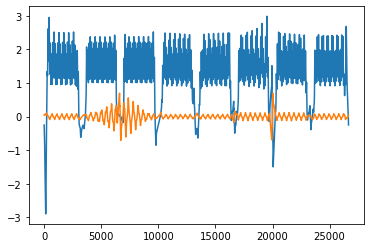

In [30]:
plt.plot(twiss["s"], twiss["dx"])
plt.plot(twiss["s"], twiss["dy"])

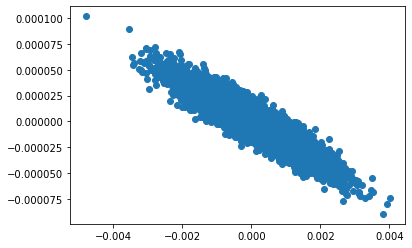

In [27]:
plt.scatter(tmp_p.x, tmp_p.px)

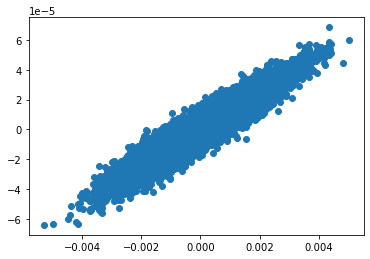

In [28]:
plt.scatter(tmp_p.y, tmp_p.py)

In [16]:
gemitt_x, gemitt_y = get_gemitt(line.particle_ref, twiss_data)
print("gemitt_x", gemitt_x)
print("gemitt_y", gemitt_y)

gemitt_x 3.350971743430323e-10
gemitt_y 3.350971743430323e-10


In [34]:
part_norm_to_phys = line.build_particles(
    _context=_context,
    x_norm=[5.0],
    px_norm=[0.0],
    y_norm=[2.0],
    py_norm=[0.0],
    zeta_norm=[0.0],
    pzeta_norm=[0.0],
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
)

# print all coordinates of part_norm_to_phys
print("x:", part_norm_to_phys.x)
print("px:", part_norm_to_phys.px)
print("y:", part_norm_to_phys.y)
print("py:", part_norm_to_phys.py)
print("zeta:", part_norm_to_phys.zeta)
print("ptau:", part_norm_to_phys.ptau)

twiss.get_normalized_coordinates(part_norm_to_phys, nemitt_x, nemitt_y)

x: [0.00101345]
px: [-1.94089939e-05]
y: [0.00053523]
py: [6.57948498e-06]
zeta: [2.24530354e-05]
ptau: [5.73712859e-06]


Table: 1 row, 8 cols
particle_id at_element x_norm      px_norm y_norm     py_norm  zeta_norm ...
          0          0      5 -3.47616e-15      2 9.89056e-16 4.1359e-23

In [31]:
part_norm_to_phys = line.build_particles(
    _context=_context,
    x_norm=[1.0],
    px_norm=[0.0],
    y_norm=[2.0],
    py_norm=[0.0],
    zeta_norm=[0.0],
    pzeta_norm=[0.0],
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
)

# print all coordinates of part_norm_to_phys
print("x:", part_norm_to_phys.x)
print("px:", part_norm_to_phys.px)
print("y:", part_norm_to_phys.y)
print("py:", part_norm_to_phys.py)
print("zeta:", part_norm_to_phys.zeta)
print("ptau:", part_norm_to_phys.ptau)

x: [0.00020074]
px: [-3.93269692e-06]
y: [0.00054065]
py: [6.66055876e-06]
zeta: [9.07074192e-06]
ptau: [5.73665289e-06]


In [23]:
twiss_data

array([ 2.50000000e-06,  2.50000000e-06, -2.02594914e-07, -9.65900346e-08,
        6.45129379e-08,  4.42997896e-09,  5.96749128e-06,  5.73638277e-06])

In [24]:
part_norm_to_phys.beta0

LinkedArrayCpu([0.99999999])

In [30]:
import scipy.constants as const

def x_m_to_sigma(x_m):
    proton_mass = const.m_p # kg

    # energy at 7 TeV
    proton_energy = 7000e9 # eV
    # tev to joule
    proton_energy *= const.e # J

    # get gamma
    proton_gamma = proton_energy/proton_mass/const.c**2

    # get beta
    proton_beta = np.sqrt(1 - 1/proton_gamma**2)

    beta_x = 117.83 # m
    beta_y = 219.64 # m
    beta_gamma = proton_beta * proton_gamma
    nom_emittance = 2.5e-6 # m

    phys_emittance = nom_emittance / (beta_gamma)

    return x_m / (np.sqrt(beta_x * phys_emittance))

x_m_to_sigma(0.00365475)

18.392651885878653

In [33]:
part_norm_to_phys.x_norm

AttributeError: 'Particles' object has no attribute 'x_norm'